# 16 - Exploration of Historical NBA Players (Part VII, PCA on 2016 Teams)

I'm starting to get a foothold oh leveraging PCA to understand the makeup of a team from their players' PCA bi-plots. It's really been a useful tool to see where teams were strong, where teams were weak, and the overall balance of a team.

Like I left off last time, I'd now like to look at all of the 2016 teams in totality and just do a visual inspection. This is more or less a python / R / rpy2 challenge to figure out how to automate. Leggo.

In [43]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [44]:
%%R
# Load libraries & initial config
library(ggplot2)
library(gridExtra)
library(scales)
library(ggbiplot)

In [45]:
# Load libraries & initial config
%matplotlib nbagg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import boto3
from StringIO import StringIO
import warnings
warnings.filterwarnings('ignore')

In [46]:
# Retrieve team stats from S3
playerAggDfToAnalyze = pd.read_csv('https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/data/playerAggDfToAnalyze.csv', index_col = 0)

pd.set_option('display.max_rows', len(playerAggDfToAnalyze.dtypes))
print playerAggDfToAnalyze.dtypes
pd.reset_option('display.max_rows')

season_start_year          int64
perGameStats_Player       object
perGameStats_Pos          object
perGameStats_Age           int64
perGameStats_Tm           object
perGameStats_G             int64
perGameStats_GS          float64
perGameStats_MP          float64
per100Stats_FG           float64
per100Stats_FGA          float64
per100Stats_FGPerc       float64
per100Stats_3P           float64
per100Stats_3PA          float64
per100Stats_3PPerc       float64
per100Stats_2P           float64
per100Stats_2PA          float64
per100Stats_2PPerc       float64
per100Stats_FT           float64
per100Stats_FTA          float64
per100Stats_FTPerc       float64
per100Stats_ORB          float64
per100Stats_DRB          float64
per100Stats_TRB          float64
per100Stats_AST          float64
per100Stats_STL          float64
per100Stats_BLK          float64
per100Stats_TOV          float64
per100Stats_PF           float64
per100Stats_PTS          float64
per100Stats_ORtg         float64
per100Stat

In [47]:
# Filter to remove outliers, player must have played over 10 minutes and in over 20 games on the season
playerAggDfToAnalyzeMin10Min20Games = playerAggDfToAnalyze[(playerAggDfToAnalyze['perGameStats_MP'] > 10) & (playerAggDfToAnalyze['perGameStats_G'] > 20)]

In [275]:
# Define a function to take in a year and a team, the function will calculate who the starters are, perform the PCA transformation
#   and then plot the starters on the PCA plot
def teamPlayerReBiplotSize(seasonStartYear, team):
    # Select subset of features
    playerAggDfToAnalyzeMin10Min20GamesPCAFeatures = playerAggDfToAnalyzeMin10Min20Games[[
        'season_start_year',
        'perGameStats_Tm',
        'perGameStats_Player',
        'perGameStats_MP',
        'perGameStats_GS',
        'per100Stats_ORB',
        'per100Stats_DRB',
        'per100Stats_AST',
        'per100Stats_STL',
        'per100Stats_BLK',
        'per100Stats_PTS'
    ]].dropna().reset_index(drop = True)
    
    # Create a copy of the dataframe with shorter name for readability
    pcaFeaturesDf = playerAggDfToAnalyzeMin10Min20GamesPCAFeatures
    
    # Calculate the 5 players on the given team with the most games started, get their index into a list
    startersDfIndexes = pcaFeaturesDf[
        (pcaFeaturesDf['season_start_year'] == seasonStartYear) & (pcaFeaturesDf['perGameStats_Tm'] == team)
    ].sort_values(
        'perGameStats_MP',
        ascending = False
    ).head(10).index.tolist()
    
    # Print the starters statlines
    playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesStatlines = playerAggDfToAnalyzeMin10Min20GamesPCAFeatures[playerAggDfToAnalyzeMin10Min20GamesPCAFeatures.index.isin(startersDfIndexes)][[
        'perGameStats_Player',
        'perGameStats_MP',
        'per100Stats_PTS',
        'per100Stats_ORB',
        'per100Stats_DRB',
        'per100Stats_AST',
        'per100Stats_STL',
        'per100Stats_BLK'  
    ]]

    # For those players found, output them to the label to pass to ggbiplot, otherwise label to blank category
    playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesLabel = np.where(
        playerAggDfToAnalyzeMin10Min20GamesPCAFeatures.index.isin(startersDfIndexes),
        playerAggDfToAnalyzeMin10Min20GamesPCAFeatures['perGameStats_Player'],
        ''
    ).tolist()
    
    # For those players found, output sizes proportional to their PTS / TRB / AST / STL / BLK to size points / labels
    playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesSize = np.where(
        playerAggDfToAnalyzeMin10Min20GamesPCAFeatures.index.isin(startersDfIndexes),
        (
            playerAggDfToAnalyzeMin10Min20GamesPCAFeatures['per100Stats_ORB'] + 
            playerAggDfToAnalyzeMin10Min20GamesPCAFeatures['per100Stats_DRB'] * 0.8 + 
            playerAggDfToAnalyzeMin10Min20GamesPCAFeatures['per100Stats_AST'] + 
            playerAggDfToAnalyzeMin10Min20GamesPCAFeatures['per100Stats_STL'] * 2 + 
            playerAggDfToAnalyzeMin10Min20GamesPCAFeatures['per100Stats_BLK'] * 2
        ) / 5,
        0
    ).tolist()
    
    # For those players found, take values of their MP and we'll correlate it to colors
    playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesColor = np.where(
        playerAggDfToAnalyzeMin10Min20GamesPCAFeatures.index.isin(startersDfIndexes),
        playerAggDfToAnalyzeMin10Min20GamesPCAFeatures['perGameStats_MP'],
        10
    ).tolist()
        
    # Structure data to pass to R's prcomp()
    playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesData = playerAggDfToAnalyzeMin10Min20GamesPCAFeatures.drop(['season_start_year', 'perGameStats_Tm', 'perGameStats_Player', 'perGameStats_GS', 'perGameStats_MP'], 1)
    
    # Return labels and data to pass to R
    return playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesStatlines, playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesColor, playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesSize, playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesLabel, playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesData

In [299]:
%%R

pcaPlayerBiplotSize = function(team, colors, sizes, labels, data){
    pca = prcomp(data, center = T, scale = T)
    firstTwoComp = data.frame(pca$x)[c('PC1', 'PC2')]
    finalDf = cbind(firstTwoComp, colors, sizes, labels)
    
    return (
                ggbiplot(
                    pca, 
                    obs.scale = 1, 
                    var.scale = 1, 
                    circle = TRUE, 
                    alpha = 0
                ) + 
                geom_text(
                    data = finalDf,
                    aes(
                        x = PC1,
                        y = PC2,
                        label = labels,
                        color = colors
                    ),
                    size = sizes,
                ) +
                scale_colour_gradient(low = 'white', high = 'blue') +
                theme(legend.position="none") +
                ggtitle(team)
           )
}

Alright, after a million lines of code, I'm ready to generate all the plots. The difficult part here is that I can't pass a dictionary from python into rpy2, so I can't create a dict of populated dataframes and just pass them all in. I'll probably have to pass them one by one into R and then somehow loop the visulization portion within R as well.

In [300]:
# Initiate list of dataframes in R
%R allData = list()

# Get unique teams in 2016
teams2016 = playerAggDfToAnalyzeMin10Min20Games[playerAggDfToAnalyzeMin10Min20Games['season_start_year'] == 2016]['perGameStats_Tm'].sort_values().unique()

# For each team, generate the dataframe of PCA features and pass to R
for team in teams2016:
    statlines, colors, sizes, labels, data = teamPlayerReBiplotSize(2016, team)
    %R -i team -i colors -i sizes -i labels -i data
    %R allData[[team]] = list()
    %R allData[[team]][['colors']] = colors
    %R allData[[team]][['sizes']] = sizes
    %R allData[[team]][['labels']] = labels
    %R allData[[team]][['data']] = data

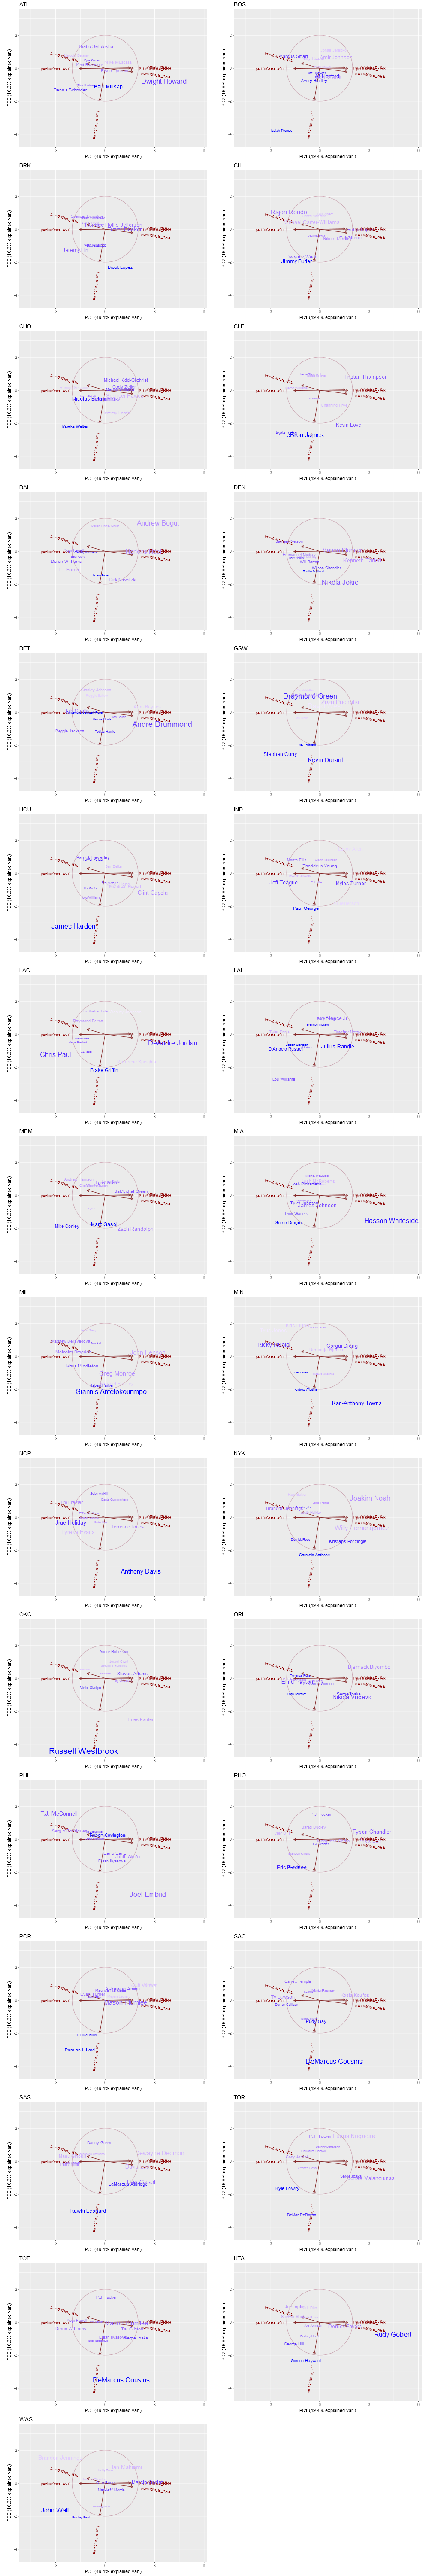

In [301]:
%%R -i teams2016 -w 1000 -h 6000 -u px

allPlots = list()

# Generate each plot object for each team
for (team in teams2016) {
    allPlots[[team]] = pcaPlayerBiplotSize(team, allData[[team]][['colors']], allData[[team]][['sizes']], allData[[team]][['labels']], allData[[team]][['data']])
}

# Plot all the objects together in one grid
do.call(grid.arrange, c(allPlots, ncol = 2))

Okay, so you might have noticed that I modified the plot with yet **another dimension** as well. I think I'm really starting to push this plot to the limit in terms of everything it can show. We'll see if it becomes too much. I wanted an easy way to differentiate between those who are EXTREMELY efficient, but only play like 14 MPG. I was getting those Lou Amundsons on the 2000 PHO that just stood out so much, but in reality he barely saw minutes (although, again, not taking anything away from his efficiency)!

What I did was **correlate MPG with the color of their label**. Players who played more will jump out at you with a darker blue, otherwise they fade away to white.

## Using The Plot
With all these dimensions, I can get such a quick sense of how players are performing and how teams are structured.

I can almost immediately see who the all-star calibre players are. In about 5 minutes, scrolling through the plots, here are my all-stars (with of course some bias of knowing who is already an all star, but these are who I would've guessed from the plots anyways).
- Isaiah Thomas (E / G)
- Jimmy Butler (E / G)
- Kemba Walker (E / G)
- Lebron James (E / F)
- Andre Drummond (E / F)
- Kevin Durant (W / F)
- Steph Curry (W / G)
- Draymond Green (W / F)
- James Harden (W / G)
- Chris Paul (W / G)
- DeAndre Jordan / Blake Griffin (W / F)
- Mike Conley (W / G)
- Marc Gasol (W / F)
- Hassan Whiteside (E / F)
- Giannis At........mpo (E / F)
- KAT (W / F)
- Anthony Davis (W / F)
- Russell Westbrook (W / G)
- Damian Lillard (W / G)
- Demarcus Cousins (W / F)
- Kawhi (W / F)
- Kyle Lowry (E / G)
- Demar Derozan (E / G)
- Rudy Gobert (W / F)
- John Wall (E / G)

That's 25 guys right there. The first letter (E or W) is the conference, and the second letter (G or F) is position. I currently have
- 6 East Guards
- 4 East Forwards
- 6 West Guards
- 9 West Forwards

Wow, west forwards are pretty stacked. I see why the likes of KAT and Gobert got cut. On the actual list, they actually had 8 F's in the west. I definitely didn't get all the right names (actual list had Hayward as well), but I got the right idea.

The east was also interesting as the actual lineup had Paul George, Paul Millsap, and Melo who, from my plots, did not seem like extremely high contributors, although in many cases they were the leaders of their team playing heavy minutes and contributing at high efficiency. I just thought there were players who had higher contributions (especially Melo who was also on a losing team as well).

Overall, I'm really happy with the information I'm extracting from this plot. Again, we have to cognizant that, yes, it's a very very very limited view that does not tell too much of the defensive story. But for taking a really quick glance, and even going through this exercise, I'm seeing a lot of things that I wasn't seeing before. Guys like Gobert and KAT who play on less popular and less televised teams, I had only heard about their production, but seeing it relative to others is another story in itself.

## Looking Ahead
The circular nature of the bi-plot makes it extremely easy to spot outliers in efficiency and, therefore, elite / all-star calibre players. Other factors come into play as we saw once we sized the text proportionally to REB / AST / STL / BLK, we also saw the outliers in the middle of the plot surface as well (case and point Draymond Green).

I wonder how this / if this plot correlates to some advanced metrics like Win Shares or VORP or PER. I know a lot of these are based upon the basic metrics that we use here, but it would be interesting to see it plotted.